# Human protein multi-label image classification

Let's start by importing our needed libraries

In [1]:
import numpy
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision import models
from torchvision.utils import make_grid
import torchvision.transforms as T

import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm.autonotebook import tqdm

## Preparing the data

We start by preparing our data directories

In [2]:
DATA_DIR = "data/Human protein atlas"

TRAIN_DIR = DATA_DIR + "/train"
TEST_DIR = DATA_DIR + "/test"

TRAIN_CSV = DATA_DIR + "/train.csv"
TEST_CSV = "data/submission.csv"

Let's take a sneak peak inside our training labels

In [3]:
data_df = pd.read_csv(TRAIN_CSV)
data_df.head()

,Image,Label
0,19567,9
1,29993,6 4
2,17186,1 4
3,29600,6 2
4,701,3 4


And our test labels

In [4]:
test_df = pd.read_csv(TEST_CSV)
test_df.head()

,Image,Label
0,24117,0
1,15322,0
2,14546,0
3,8079,0
4,13192,0


These are our image labels

In [5]:
labels = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles'
}

We define two functions, one for encoding our labels to tensors, and one decoding tensors to labels

In [6]:
def encode_label(label):
    target = torch.zeros(10)
    for l in str(label).split(" "):
        target[int(l)] = 1.
    return target

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)

Let's what we've done

In [7]:
encode_label('3 8 9')

tensor([0., 0., 0., 1., 0., 0., 0., 0., 1., 1.])

This should produce an error

In [8]:
encode_label('9 11 2')

IndexError: index 11 is out of bounds for dimension 0 with size 10

In [9]:
target = torch.zeros(10)
target[[2,4,5]] = 1
decode_target(target)

'2 4 5'

We create a dataset, which takes in a labelling dataframe, a data directory, a transform object and will gives us back with each iteration a transformed image and the label of that image

In [10]:
class HumanProteinDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row["Image"], row["Label"]
        img_fname = self.root_dir + "/" + str(img_id) + ".png"
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, encode_label(img_label)

Now, let's make some transforms for our images. Transforms help in augmenting our already existing data with various random transformations, by performing random rotations, flips and crops.

Since we will be doing transfer learning using a pretrained ResNet, we also need to normalize our image channels with standard deviations and mean values. <br>
The ResNet we will be using has been trained on the ImageNet dataset and we need therefore to apply specific stats, which are unique to this dataset. <br>
The ImageNet means are 0.485, 0.456 and 0.406 for each channel, while the standard deviations are 0.229, 0.224 and 0.225.

## Data augmentations

In [11]:
imagenet_stats = ([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])

train_transforms = T.Compose([
    T.RandomCrop(512, padding=8, padding_mode='reflect'),
#     T.RandomResizedCrop(256),
    T.RandomHorizontalFlip(),
    T.RandomRotation(90),
    T.RandomRotation(10),
    T.ToTensor(),
#     T.Normalize(*imagenet_stats, inplace=True)
    T.RandomErasing(inplace=True)
])

valid_transforms = T.Compose([
#     T.Resize(256), 
    T.ToTensor(), 
#     T.Normalize(*imagenet_stats)
])

We split our data into training and validation

In [12]:
msk = np.random.rand(len(data_df)) < 0.9

train_df = data_df[msk].reset_index()
val_df = data_df[~msk].reset_index()

And create our training and validation sets

In [13]:
train_ds = HumanProteinDataset(train_df, TRAIN_DIR, transform=train_transforms)
val_ds = HumanProteinDataset(val_df, TRAIN_DIR, transform=valid_transforms)
len(train_ds), len(val_ds)

(17417, 1819)

We create a new function which will display a single image taken from our dataset and its label

In [14]:
def show_sample(img, target, invert=True):
    img = img.permute((1,2,0))
    if invert:
        plt.imshow(1 - img)
    else:
        plt.imshow(img)
    print("Labels:", decode_target(target, text_labels=True))

Now let's see some samples

Labels: Cytosol(6)


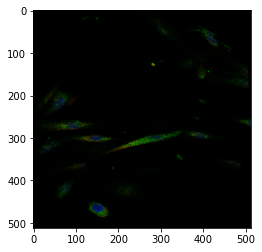

In [15]:
show_sample(*train_ds[1541], invert=False)

Labels: Nucleoplasm(4)


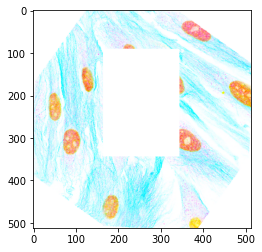

In [16]:
show_sample(*train_ds[15652], invert=True)

In [17]:
# validation_percentage = 0.15
# val_size = int(validation_percentage*len(dataset))
# train_size = len(dataset) - val_size

In [18]:
# train_ds, val_ds = random_split(dataset, [train_size, val_size])
# len(train_ds), len(val_ds)

## Dataloaders

We set a batch size of 20, which is the best we can do with our GPU

In [19]:
batch_size = 10

And build our dataloaders

In [20]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)

We create a new function which will display a single batch of our data

In [21]:
def show_batch(dl, invert=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16,8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=10).permute(1,2,0))
        break

/home/will/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/cuda/__init__.py:87: UserWarning: 
    Found GPU1 GeForce GTX 660 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


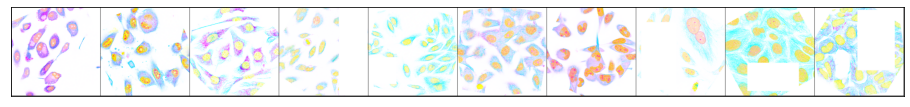

In [22]:
show_batch(train_dl, True)

##  Model

Before we begin creating our model, let's create our loss function, the F-1 score. <br>
If you would like to know more about the F1 score you can read more about it here <br>
https://www.educative.io/edpresso/what-is-the-f1-score

In [23]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold
    
    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()
    
    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean()

Let's now create the base for our model. This will include training, validation step and end functions

In [24]:
class MultiLabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch
        out = self(images)
        loss = F.binary_cross_entropy(out, targets)
        return loss
    
    def validation_step(self, batch):
        images, targets = batch
        out = self(images)
        loss = F.binary_cross_entropy(out, targets)
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach()}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score']))

We will use the 50 layer ResNet for our training

In [25]:
resnet50 = models.resnet50()
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

We build our model using the base we created earlier

In [26]:
class ProteinResnet(MultiLabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace the classifier with our own
        num_features = self.network.fc.in_features
        self.network.fc = nn.Linear(num_features, 10)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # This is used to freeze the convolutional layers of the model and only leave the classifier to train
        for param in self.network.parameters():
            param.requires_grad = False
        for param in self.network.fc.parameters():
            param.requires_grad = True
    
    def unfreeze(self):
        # Unfreezes convolutional layers, the opposite of freeze
        for param in self.network.parameters():
            param.requires_grad = True

We build some helper functions which will aid us in transfering tensors to a CUDA device

In [27]:
def get_default_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

And create our own custom device dataloader

In [28]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

What device are we using?

In [29]:
device = get_default_device()
device

device(type='cuda')

We create our custom training and validation dataloaders

In [30]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

## Training

We define the validation and training functions

In [31]:
@torch.no_grad() # this is used to signify that no gradient descent will be performed for this function
def evaluate(model, val_loader):
    # we disable dropout and batch normalization layers
    model.eval()
    outputs = [model.validation_step(batch) for batch in tqdm(val_loader)]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, max_lr, model, train_loader, val_loader, 
        weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    # we empty the cude memory before performing anything
    # this helps in allocating more space for training to run
    # and prevent CUDA out of memory errors
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # set up learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                               steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training phase
        # we enable dropout and batch normalization layers
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            
            # record learning rate
            lrs.append(get_lr(optimizer))
            # perform scheduler step
            sched.step()
        # Validation phase
        else:
            result = evaluate(model, val_loader)
            result['train_loss'] = torch.stack(train_losses).mean().item()
            result['lrs'] = lrs
            model.epoch_end(epoch, result)
            history.append(result)
    return history

We make a new model and send it to our GPU/CPU RAM

In [32]:
model = to_device(ProteinResnet(), device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/will/.cache/torch/checkpoints/resnet50-19c8e357.pth


What is the performance of our model without any training?

In [33]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 0.690554141998291, 'val_score': 0.2110920399427414}]

We freeze all layers of the models excluding the classifier

In [34]:
model.freeze()

We set some hyperparameters and begin our training

In [35]:
num_epochs = 5
max_lr = 1e-2
grad_clip = 0.1
weight_decay = 5 * 1e-4
opt_func = torch.optim.Adam

In [36]:
total_time_in_sec = 0

# we calculate how much time it took to train our model
start = time.time()

history += fit(num_epochs, max_lr, model, train_dl, val_dl, 
              grad_clip=grad_clip, weight_decay=weight_decay, 
              opt_func=opt_func)

total_time_in_sec += start - time.time()


Epoch [0], last_lr: 0.0076, train_loss: 0.3935, val_loss: 0.4108, val_score: 0.4950



Epoch [1], last_lr: 0.0095, train_loss: 0.5240, val_loss: 0.4294, val_score: 0.4413



Epoch [2], last_lr: 0.0061, train_loss: 0.4589, val_loss: 0.4524, val_score: 0.3775



Epoch [3], last_lr: 0.0019, train_loss: 0.3740, val_loss: 0.3110, val_score: 0.3853



Epoch [4], last_lr: 0.0000, train_loss: 0.3137, val_loss: 0.2850, val_score: 0.4618


In [37]:
max_lr = 0.0005

start = time.time()

history += fit(num_epochs, max_lr, model, train_dl, val_dl, 
              grad_clip=grad_clip, weight_decay=weight_decay, 
              opt_func=opt_func)

total_time_in_sec += start - time.time()


Epoch [0], last_lr: 0.0004, train_loss: 0.3017, val_loss: 0.2946, val_score: 0.4418



Epoch [1], last_lr: 0.0005, train_loss: 0.3096, val_loss: 0.2937, val_score: 0.4345



Epoch [2], last_lr: 0.0003, train_loss: 0.3070, val_loss: 0.2952, val_score: 0.4709



Epoch [3], last_lr: 0.0001, train_loss: 0.3031, val_loss: 0.2856, val_score: 0.4897



Epoch [4], last_lr: 0.0000, train_loss: 0.2985, val_loss: 0.2831, val_score: 0.4524


In [38]:
model.unfreeze()

In [39]:
start = time.time()

history += fit(num_epochs, max_lr, model, train_dl, val_dl, 
              grad_clip=grad_clip, weight_decay=weight_decay, 
              opt_func=opt_func)

total_time_in_sec += start - time.time()


Epoch [0], last_lr: 0.0004, train_loss: 0.2755, val_loss: 0.2958, val_score: 0.5902



Epoch [1], last_lr: 0.0005, train_loss: 0.2719, val_loss: 0.2725, val_score: 0.5833



Epoch [2], last_lr: 0.0003, train_loss: 0.2655, val_loss: 0.2987, val_score: 0.6451



Epoch [3], last_lr: 0.0001, train_loss: 0.2433, val_loss: 0.2081, val_score: 0.6953



Epoch [4], last_lr: 0.0000, train_loss: 0.2199, val_loss: 0.1911, val_score: 0.7480


In [40]:
num_epochs = 10
max_lr = 0.0001

start = time.time()

history += fit(num_epochs, max_lr, model, train_dl, val_dl, 
              grad_clip=grad_clip, weight_decay=weight_decay, 
              opt_func=opt_func)

total_time_in_sec += start - time.time()


Epoch [0], last_lr: 0.0000, train_loss: 0.2127, val_loss: 0.1896, val_score: 0.7425



Epoch [1], last_lr: 0.0001, train_loss: 0.2143, val_loss: 0.1984, val_score: 0.7446



Epoch [2], last_lr: 0.0001, train_loss: 0.2173, val_loss: 0.2207, val_score: 0.7141



Epoch [3], last_lr: 0.0001, train_loss: 0.2153, val_loss: 0.1913, val_score: 0.7151



Epoch [4], last_lr: 0.0001, train_loss: 0.2107, val_loss: 0.1882, val_score: 0.7554



Epoch [5], last_lr: 0.0001, train_loss: 0.2062, val_loss: 0.1905, val_score: 0.7530



Epoch [6], last_lr: 0.0000, train_loss: 0.1989, val_loss: 0.1792, val_score: 0.7653



Epoch [7], last_lr: 0.0000, train_loss: 0.1941, val_loss: 0.1710, val_score: 0.7741



Epoch [8], last_lr: 0.0000, train_loss: 0.1891, val_loss: 0.1704, val_score: 0.7741



Epoch [9], last_lr: 0.0000, train_loss: 0.1855, val_loss: 0.1689, val_score: 0.7782


In [41]:
max_lr = 1e-5

start = time.time()

history += fit(num_epochs, max_lr, model, train_dl, val_dl, 
              grad_clip=grad_clip, weight_decay=weight_decay, 
              opt_func=opt_func)

total_time_in_sec += start - time.time()


Epoch [0], last_lr: 0.0000, train_loss: 0.1849, val_loss: 0.1698, val_score: 0.7762



Epoch [1], last_lr: 0.0000, train_loss: 0.1856, val_loss: 0.1708, val_score: 0.7809



Epoch [2], last_lr: 0.0000, train_loss: 0.1859, val_loss: 0.1699, val_score: 0.7826



Epoch [3], last_lr: 0.0000, train_loss: 0.1853, val_loss: 0.1710, val_score: 0.7807



Epoch [4], last_lr: 0.0000, train_loss: 0.1844, val_loss: 0.1688, val_score: 0.7829



Epoch [5], last_lr: 0.0000, train_loss: 0.1829, val_loss: 0.1699, val_score: 0.7723



Epoch [6], last_lr: 0.0000, train_loss: 0.1815, val_loss: 0.1706, val_score: 0.7729



Epoch [7], last_lr: 0.0000, train_loss: 0.1802, val_loss: 0.1701, val_score: 0.7772



Epoch [8], last_lr: 0.0000, train_loss: 0.1796, val_loss: 0.1671, val_score: 0.7817



Epoch [9], last_lr: 0.0000, train_loss: 0.1798, val_loss: 0.1684, val_score: 0.7771


In [42]:
data_ds = HumanProteinDataset(data_df, TRAIN_DIR, transform=train_transforms)
data_dl = DataLoader(data_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
data_dl = DeviceDataLoader(data_dl, device)

In [43]:
max_lr = 1e-5

start = time.time()

history += fit(num_epochs, max_lr, model, data_dl, val_dl, 
              grad_clip=grad_clip, weight_decay=weight_decay, 
              opt_func=opt_func)

total_time_in_sec += start - time.time()


Epoch [0], last_lr: 0.0000, train_loss: 0.1800, val_loss: 0.1689, val_score: 0.7590



Epoch [1], last_lr: 0.0000, train_loss: 0.1803, val_loss: 0.1693, val_score: 0.7651



Epoch [2], last_lr: 0.0000, train_loss: 0.1803, val_loss: 0.1688, val_score: 0.7634



Epoch [3], last_lr: 0.0000, train_loss: 0.1806, val_loss: 0.1677, val_score: 0.7691



Epoch [4], last_lr: 0.0000, train_loss: 0.1797, val_loss: 0.1691, val_score: 0.7653



Epoch [5], last_lr: 0.0000, train_loss: 0.1771, val_loss: 0.1672, val_score: 0.7662



Epoch [6], last_lr: 0.0000, train_loss: 0.1779, val_loss: 0.1655, val_score: 0.7651



Epoch [7], last_lr: 0.0000, train_loss: 0.1763, val_loss: 0.1656, val_score: 0.7658



Epoch [8], last_lr: 0.0000, train_loss: 0.1752, val_loss: 0.1651, val_score: 0.7738



Epoch [9], last_lr: 0.0000, train_loss: 0.1750, val_loss: 0.1637, val_score: 0.7742


In [44]:
torch.save(model, "model2.pth")

/home/will/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ProteinResnet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [46]:
max_lr = 1e-6
num_epochs = 4

start = time.time()

history += fit(num_epochs, max_lr, model, data_dl, val_dl, 
              grad_clip=grad_clip, weight_decay=weight_decay, 
              opt_func=opt_func)

total_time_in_sec += start - time.time()

torch.save(model, "model2.pth")


Epoch [0], last_lr: 0.0000, train_loss: 0.1751, val_loss: 0.1591, val_score: 0.7886



Epoch [1], last_lr: 0.0000, train_loss: 0.1753, val_loss: 0.1610, val_score: 0.7882



Epoch [2], last_lr: 0.0000, train_loss: 0.1748, val_loss: 0.1596, val_score: 0.7873



Epoch [3], last_lr: 0.0000, train_loss: 0.1745, val_loss: 0.1586, val_score: 0.7912


In [47]:
max_lr = 1e-7
num_epochs = 2

start = time.time()

history += fit(num_epochs, max_lr, model, data_dl, val_dl, 
              grad_clip=grad_clip, weight_decay=weight_decay, 
              opt_func=opt_func)

total_time_in_sec += start - time.time()

torch.save(model, "model2.pth")


Epoch [0], last_lr: 0.0000, train_loss: 0.1753, val_loss: 0.1591, val_score: 0.7879



Epoch [1], last_lr: 0.0000, train_loss: 0.1746, val_loss: 0.1582, val_score: 0.7889


In [48]:
max_lr = 1e-8

start = time.time()

history += fit(num_epochs, max_lr, model, data_dl, val_dl, 
              grad_clip=grad_clip, weight_decay=weight_decay, 
              opt_func=opt_func)

total_time_in_sec += start - time.time()

torch.save(model, "model2.pth")


Epoch [0], last_lr: 0.0000, train_loss: 0.1744, val_loss: 0.1577, val_score: 0.7907



Epoch [1], last_lr: 0.0000, train_loss: 0.1743, val_loss: 0.1595, val_score: 0.7896


In [52]:
torch.cuda.empty_cache()

In [53]:
model = torch.load("model2.pth")

In [54]:
max_lr = 1e-9

start = time.time()

history += fit(num_epochs, max_lr, model, data_dl, val_dl, 
              grad_clip=grad_clip, weight_decay=weight_decay, 
              opt_func=opt_func)

total_time_in_sec += start - time.time()

torch.save(model, "model2.pth")


Epoch [0], last_lr: 0.0000, train_loss: 0.1745, val_loss: 0.1573, val_score: 0.7908



Epoch [1], last_lr: 0.0000, train_loss: 0.1747, val_loss: 0.1596, val_score: 0.7858


/home/will/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ProteinResnet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [79]:
train_transforms = T.Compose([
    T.RandomCrop(512, padding=8, padding_mode='reflect'),
#     T.RandomResizedCrop(256),
    T.RandomHorizontalFlip(),
    T.RandomRotation(90),
    T.RandomRotation(10),
    T.ToTensor(),
#     T.Normalize(*imagenet_stats, inplace=True)
])

data_ds = HumanProteinDataset(data_df, TRAIN_DIR, transform=train_transforms)
data_dl = DataLoader(data_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
data_dl = DeviceDataLoader(data_dl, device)

In [80]:
start = time.time()

history += fit(num_epochs, max_lr, model, data_dl, val_dl, 
              grad_clip=grad_clip, weight_decay=weight_decay, 
              opt_func=opt_func)

total_time_in_sec += start - time.time()

torch.save(model, "model2.pth")


Epoch [0], last_lr: 0.0000, train_loss: 0.1722, val_loss: 0.1593, val_score: 0.7894



Epoch [1], last_lr: 0.0000, train_loss: 0.1714, val_loss: 0.1607, val_score: 0.7826


/home/will/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ProteinResnet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [81]:
-total_time_in_sec / (60 * 60)

17.66503680176205

In [82]:
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score vs No. of epochs')

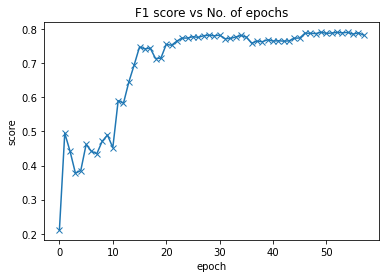

In [83]:
plot_scores(history)

In [84]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

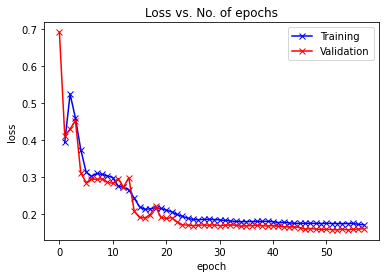

In [85]:
plot_losses(history)

In [86]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

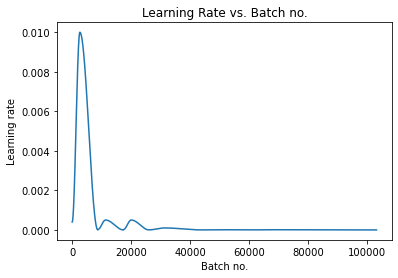

In [87]:
plot_lrs(history)

In [88]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    print("Prediction: ", prediction)
    show_sample(image, prediction)

In [89]:
test_df = pd.read_csv(TEST_CSV)
test_dataset = HumanProteinDataset(test_df, TEST_DIR, transform=T.ToTensor())

In [90]:
img, target = test_dataset[0]
img.shape

torch.Size([3, 512, 512])

Prediction:  tensor([3.2292e-03, 1.5521e-02, 6.0121e-02, 6.9937e-03, 9.9107e-01, 3.4738e-03,
        9.2705e-01, 1.4778e-02, 8.0426e-03, 6.8021e-04], device='cuda:0',
       grad_fn=<SelectBackward>)
Labels: Nucleoplasm(4) Cytosol(6)


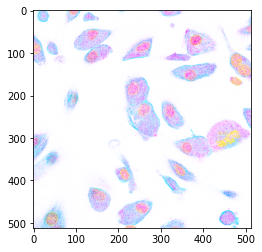

In [91]:
predict_single(test_dataset[100][0])

Prediction:  tensor([0.8978, 0.0083, 0.0101, 0.1630, 0.0340, 0.0051, 0.0364, 0.0105, 0.0210,
        0.0060], device='cuda:0', grad_fn=<SelectBackward>)
Labels: Mitochondria(0)


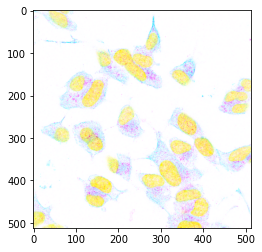

In [92]:
predict_single(test_dataset[74][0])

In [93]:
test_dl = DeviceDataLoader(DataLoader(test_dataset, batch_size, pin_memory=True), device)

In [94]:
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_probs = []
    for xb, _ in tqdm(dl):
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    return [decode_target(x) for x in batch_probs]

In [95]:
test_preds = predict_dl(test_dl, model)

In [96]:
submission_df = pd.read_csv(TEST_CSV)
submission_df.Label = test_preds
submission_df.sample(20)

,Image,Label
776,1792,3
1582,4919,4 7
7737,9942,4
604,19864,4 9
1975,8816,4 6
1604,2185,2
359,28292,4
1767,13247,0 7
1859,13031,2 4
500,17533,1 4


In [97]:
sub_fname = 'submission2.csv'

In [98]:
submission_df.to_csv(sub_fname, index=False)

In [99]:
weights_fname = 'protein-resnet2.pth'
torch.save(model.state_dict(), weights_fname)

In [100]:
import jovian

In [101]:
jovian.reset()
jovian.log_hyperparams(arch='resnet34', 
                       epochs=[5,5,5,10,10,10,4,2,2,2,2], 
                       lr=[1e-2, 5*1e-4, 5*1e-4, 1e-4, 1e-5, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-9], 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Hyperparams logged.


In [102]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_score=history[-1]['val_score'],
                   train_loss=history[-1]['train_loss'],
                   time= -total_time_in_sec / (60))

[jovian] Metrics logged.


In [103]:
project_name='protein-advanced'

In [104]:
jovian.commit(project=project_name, environment=None, outputs=[weights_fname])

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "will-enkhai/protein-advanced" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/will-enkhai/protein-advanced


'https://jovian.ml/will-enkhai/protein-advanced'